In [248]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Pre Procesado

In [249]:
df = pd.read_csv( "/home/bautista/Datos/Machine-Learning-Datos/Training.csv" )
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,Closed Lost,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,8781,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16943,8786,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q2,2016,NaT,0,EUR,93015.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16944,8792,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16945,28561,Americas,NE America,1,1,1,1,0,Bureaucratic_Code_4,10/20/2015,...,Q2,2016,NaT,4,USD,2346796.88,USD,0.0,Closed Lost,Prod_Category_A_None


In [250]:
df['Total_Amount'].isnull().sum()

59

In [251]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [252]:
df['Total_Amount'].isnull().sum()

59

In [253]:
short_df = df[['Opportunity_ID','Region','Total_Amount','Bureaucratic_Code_0_Approval','Bureaucratic_Code_0_Approved','TRF','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr','Stage' ]].rename(columns={'Stage': 'Decision'})
short_df = short_df[ (short_df['Decision'] == 'Closed Won') | (short_df['Decision'] == 'Closed Lost') ]
short_df['Decision'] = np.where(short_df['Decision'] == 'Closed Won',1,0)
short_df.set_index('Opportunity_ID', inplace = True)
short_df

,Region,Total_Amount,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
Opportunity_ID,,,,,,,,
0,EMEA,6169176.00,1,1,10,1,1,0
1,EMEA,56429.10,0,0,0,0,0,1
2,Americas,83865.60,0,0,0,0,0,1
3,Americas,7421881.50,1,0,14,0,1,0
4,Americas,13357192.50,1,0,25,0,1,0
...,...,...,...,...,...,...,...,...
12801,EMEA,120919.50,1,1,0,1,1,1
12801,EMEA,108827.55,1,1,0,1,1,1
12801,EMEA,120919.50,1,1,0,1,1,1


# Feature transformation

In [254]:
short_df = short_df[short_df['Total_Amount'] > 0]
short_df.describe()

,Total_Amount,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
count,1.677200e+04,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000
mean,1.010612e+06,0.473527,0.318686,2.281660,0.585440,0.807834,0.568030
std,5.873179e+06,0.499314,0.465981,12.084678,0.492661,0.394014,0.495365
min,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.750453e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,7.714000e+04,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,2.914669e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.150001e+08,1.000000,1.000000,500.000000,1.000000,1.000000,1.000000


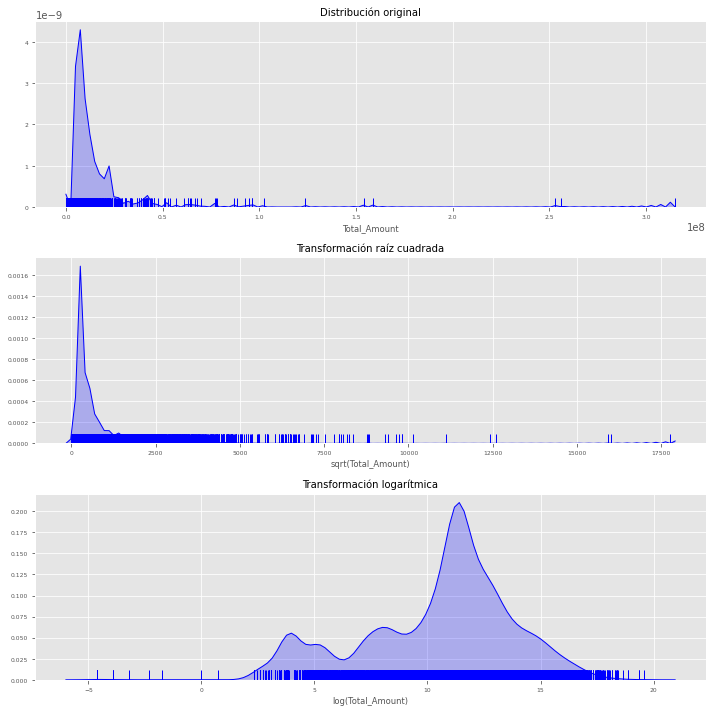

In [255]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
sns.distplot(
    short_df.Total_Amount,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Total_Amount', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(short_df.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Total_Amount)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(short_df.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Total_Amount)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [256]:
short_df.Total_Amount = np.log(short_df.Total_Amount)
short_df.shape

(16772, 8)

In [257]:
#uso para ver los feature importance.
#vector_binario = np.zeros(short_df.shape[0])
#for i in range(short_df.shape[0]):
#       if (i%2):
#           vector_binario[i] = 1
#short_df['feature_binario'] = vector_binario
#short_df

# Train y Test

In [258]:


# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat,numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12579 entries, 0 to 12578
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Region_APAC                         12579 non-null  float64
 1   Region_Americas                     12579 non-null  float64
 2   Region_EMEA                         12579 non-null  float64
 3   Region_Japan                        12579 non-null  float64
 4   Region_Middle East                  12579 non-null  float64
 5   Total_Amount                        12579 non-null  float64
 6   Bureaucratic_Code_0_Approval        12579 non-null  float64
 7   Bureaucratic_Code_0_Approved        12579 non-null  float64
 8   TRF                                 12579 non-null  float64
 9   Pricing, Delivery_Terms_Approved    12579 non-null  float64
 10  Pricing, Delivery_Terms_Quote_Appr  12579 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


# Encoding

In [259]:
X_train_prep['Total_Amount'].value_counts()

4.086312     375
3.743368     334
5.152135     258
7.203406     209
2.731767     161
            ... 
9.888272       1
13.286385      1
10.597634      1
12.582474      1
0.000000       1
Name: Total_Amount, Length: 7386, dtype: int64

In [260]:
X_train_prep

,Region_APAC,Region_Americas,Region_EMEA,Region_Japan,Region_Middle East,Total_Amount,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
0,0.0,0.0,0.0,1.0,0.0,16.166902,1.0,0.0,30.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,9.922952,1.0,1.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,9.682704,1.0,1.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,0.0,10.608936,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,11.353461,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12574,0.0,0.0,0.0,1.0,0.0,4.086312,0.0,0.0,0.0,0.0,1.0
12575,0.0,0.0,0.0,1.0,0.0,5.933751,0.0,0.0,0.0,1.0,1.0
12576,1.0,0.0,0.0,0.0,0.0,8.825266,1.0,1.0,0.0,1.0,1.0
12577,0.0,0.0,0.0,1.0,0.0,5.714604,0.0,0.0,0.0,1.0,1.0


In [261]:


# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12579 entries, 0 to 12578
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Total_Amount                        12579 non-null  float64
 1   Bureaucratic_Code_0_Approval        12579 non-null  float64
 2   Bureaucratic_Code_0_Approved        12579 non-null  float64
 3   TRF                                 12579 non-null  float64
 4   Pricing, Delivery_Terms_Approved    12579 non-null  float64
 5   Pricing, Delivery_Terms_Quote_Appr  12579 non-null  float64
 6   Region_APAC                         12579 non-null  float64
 7   Region_Americas                     12579 non-null  float64
 8   Region_EMEA                         12579 non-null  float64
 9   Region_Japan                        12579 non-null  float64
 10  Region_Middle East                  12579 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


# Grid Serch de Hiperparametros

In [262]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train_prep, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
20,0.798156,entropy,10.0,9,150
8,0.797758,gini,10.0,9,150
19,0.795055,entropy,10.0,7,150
7,0.794419,gini,10.0,7,150


In [263]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train_prep, y_train, RandomForestClassifier(), params) for params in param_grid]
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
20,0.798156,entropy,10.0,9,150
8,0.797758,gini,10.0,9,150
19,0.795055,entropy,10.0,7,150
7,0.794419,gini,10.0,7,150


In [264]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("--------------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_accuracy'], "accuracy")

--------------------------------------------------
Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
0.7981556562524843 : 0.7981556562524843 accuracy


In [265]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)



,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
8,gini,10,9,150,0.796699,0.007283,0.857845,0.002449
20,entropy,10,9,150,0.796619,0.006711,0.850154,0.002391
7,gini,10,7,150,0.795718,0.007845,0.854917,0.001854
19,entropy,10,7,150,0.794923,0.007184,0.848498,0.002053


In [266]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} : 0.796698505311533 accuracy


# Prediccion

In [267]:
modelo_final = grid.best_estimator_

In [268]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test_prep)
predicciones[:10]

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 1])

In [269]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[1307  494]
 [ 307 2085]]

El accuracy de test es: 80.8967326496542 %


In [270]:


print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)



              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1801
           1       0.81      0.87      0.84      2392

    accuracy                           0.81      4193
   macro avg       0.81      0.80      0.80      4193
weighted avg       0.81      0.81      0.81      4193



# Feature importance

In [271]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train_prep.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,Total_Amount,0.564278
9,Region_Japan,0.148155
4,"Pricing, Delivery_Terms_Approved",0.102475
3,TRF,0.071288
5,"Pricing, Delivery_Terms_Quote_Appr",0.039255
7,Region_Americas,0.029318
1,Bureaucratic_Code_0_Approval,0.015039
8,Region_EMEA,0.009877
2,Bureaucratic_Code_0_Approved,0.008292
6,Region_APAC,0.007196


# Kaggle

In [272]:
DataFrame_test = pd.read_csv( "/home/bautista/Datos/Machine-Learning-Datos/Test/Test.csv" )
DataFrame_test

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,...,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,...,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,...,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,...,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,...,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,16345,EMEA,KSA,1,1,0,0,0,Bureaucratic_Code_4,6/12/2017,...,2019 - 5,Q2,2019,NaT,0,USD,124740.0,USD,147750.0,Prod_Category_A_None
2547,15218,Americas,SE America,1,1,0,0,0,Bureaucratic_Code_4,6/8/2018,...,2019 - 10,Q4,2019,NaT,0,USD,45054.9,USD,45054.9,Prod_Category_A_None
2548,15224,Americas,SE America,1,1,1,1,0,Bureaucratic_Code_4,6/8/2018,...,2019 - 10,Q4,2019,NaT,0,USD,100122.0,USD,100122.0,Prod_Category_A_None
2549,7286,Americas,NE America,1,1,0,0,0,Bureaucratic_Code_4,8/29/2018,...,2019 - 8,Q3,2019,NaT,0,USD,143220.0,USD,143220.0,Prod_Category_A_None


In [273]:
DataFrame_test.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.0096
DataFrame_test.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.17
DataFrame_test.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.70
DataFrame_test.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.29
DataFrame_test.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [274]:
DataFrame_test = DataFrame_test[['Opportunity_ID','Region','Total_Amount','Bureaucratic_Code_0_Approval','Bureaucratic_Code_0_Approved','TRF','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr' ]]
DataFrame_test = DataFrame_test.drop_duplicates('Opportunity_ID',keep = 'last')
DataFrame_test.set_index('Opportunity_ID', inplace = True)
DataFrame_test

,Region,Total_Amount,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,TRF,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
Opportunity_ID,,,,,,,
10689,EMEA,126555.0,1,1,0,1,1
10690,EMEA,112464.0,1,1,0,1,1
10691,Americas,21037.5,0,0,0,1,1
10692,Americas,228327.0,1,0,1,1,1
10693,Americas,5752.5,0,0,0,0,0
...,...,...,...,...,...,...,...
12364,EMEA,124740.0,0,0,0,1,1
12365,Americas,45054.9,0,0,0,1,1
12366,Americas,100122.0,1,1,0,1,1


In [275]:
DataFrame_test.Total_Amount = np.log(DataFrame_test.Total_Amount)
DataFrame_test['Total_Amount'].describe()

count    1567.000000
mean       11.930953
std         1.990895
min         4.359014
25%        10.917225
50%        11.705435
75%        12.797007
max        19.996115
Name: Total_Amount, dtype: float64

# Encoding

In [276]:
# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = DataFrame_test.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = DataFrame_test.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
DataFrame_test_prep = preprocessor.fit_transform(DataFrame_test)

#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
DataFrame_test = pd.DataFrame(DataFrame_test, columns=labels)
DataFrame_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1567 entries, 10689 to 12368
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Total_Amount                        1567 non-null   float64
 1   Bureaucratic_Code_0_Approval        1567 non-null   int64  
 2   Bureaucratic_Code_0_Approved        1567 non-null   int64  
 3   TRF                                 1567 non-null   int64  
 4   Pricing, Delivery_Terms_Approved    1567 non-null   int64  
 5   Pricing, Delivery_Terms_Quote_Appr  1567 non-null   int64  
 6   Region_APAC                         0 non-null      float64
 7   Region_Americas                     0 non-null      float64
 8   Region_EMEA                         0 non-null      float64
 9   Region_Japan                        0 non-null      float64
 10  Region_Middle East                  0 non-null      float64
dtypes: float64(6), int64(5)
memory usage: 

In [277]:
DataFrame_test_prep = pd.DataFrame(DataFrame_test_prep, columns=labels)
DataFrame_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Total_Amount                        1567 non-null   float64
 1   Bureaucratic_Code_0_Approval        1567 non-null   float64
 2   Bureaucratic_Code_0_Approved        1567 non-null   float64
 3   TRF                                 1567 non-null   float64
 4   Pricing, Delivery_Terms_Approved    1567 non-null   float64
 5   Pricing, Delivery_Terms_Quote_Appr  1567 non-null   float64
 6   Region_APAC                         1567 non-null   float64
 7   Region_Americas                     1567 non-null   float64
 8   Region_EMEA                         1567 non-null   float64
 9   Region_Japan                        1567 non-null   float64
 10  Region_Middle East                  1567 non-null   float64
dtypes: float64(11)
memory usage: 134.8 KB


In [278]:
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
DataFrame_test_prep  = pd.DataFrame(DataFrame_test_prep, columns=labels)
DataFrame_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Total_Amount                        1567 non-null   float64
 1   Bureaucratic_Code_0_Approval        1567 non-null   float64
 2   Bureaucratic_Code_0_Approved        1567 non-null   float64
 3   TRF                                 1567 non-null   float64
 4   Pricing, Delivery_Terms_Approved    1567 non-null   float64
 5   Pricing, Delivery_Terms_Quote_Appr  1567 non-null   float64
 6   Region_APAC                         1567 non-null   float64
 7   Region_Americas                     1567 non-null   float64
 8   Region_EMEA                         1567 non-null   float64
 9   Region_Japan                        1567 non-null   float64
 10  Region_Middle East                  1567 non-null   float64
dtypes: float64(11)
memory usage: 134.8 KB


# Prediction

In [279]:
pred_posta = modelo_final.predict(X = DataFrame_test_prep)

In [280]:
prueba = DataFrame_test.reset_index()['Opportunity_ID']
prueba

0       10689
1       10690
2       10691
3       10692
4       10693
        ...  
1562    12364
1563    12365
1564    12366
1565    12367
1566    12368
Name: Opportunity_ID, Length: 1567, dtype: int64

In [281]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test.reset_index()['Opportunity_ID']
subir['target'] = pred_posta
#subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

,target
Opportunity_ID,
10689,1
10690,1
10691,0
10692,0
10693,1
...,...
12364,1
12365,0
12366,0


In [282]:
subir['target'].value_counts()

1    1105
0     462
Name: target, dtype: int64

In [283]:
subir.to_csv('RandomForest.csv')